In [68]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import time
import queue

In [61]:
path = 'data/wiki-Vote.txt'
G = nx.read_edgelist(path, delimiter='\t', create_using=nx.DiGraph, nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))

node_target = 9

# plot matrix
#plt.spy(A,marker=',')
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 7115
Number of edges: 103689
Average in degree:  14.5733
Average out degree:  14.5733


Elapsed time:  0.122946 seconds


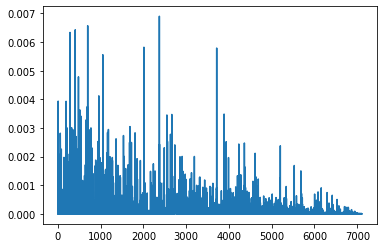

In [62]:
#compute PageRank algorith with power iteration (from network science)
def pageRank(M, t, iterations):
    N = M.shape[1]
    c = 0.85
    p = np.ones(N)/N

    for i in range(iterations):
        p = c * M * p + (1-c) * t #pagerank formula
        p = p/sum(p) #normalization

    return p


# dimension of the matrix
N = A.shape[0]

# for normal pagerank all nodes have the same teleport probability
# t = np.ones(N)/N 

# for local pagerank only a subset of nodes have non-negative probabilty
t = np.zeros(N)
t[9] = 1

start = time.time()
p = pageRank(A, t, 40)
stop = time.time()
print('Elapsed time: ', str(stop-start)[0:8], 'seconds')
plt.plot(p)
plt.show()

In [143]:
def approximatePageRank(G, target_nodes, alpha, epsilon):

    #pagerank
    p = {}

    #residuals
    r = {}
    for n in target_nodes:
        print("target node: ",n)
        p[n] = 0
        r[n] = target_nodes[n]

    #degrees
    d = {}
    for n in target_nodes:
        d[n] = G.out_degree(n)

    #queue 
    q = queue.Queue()
    for n in target_nodes:
        if r[n]/d[n] >= epsilon:
            q.put(n)

    while(q.qsize()>0):
        #print("queue size: ",q.qsize())
        #print(q.queue)
        node_u = q.get()
        
        #pu = p[node_u]
        ru = r[node_u]
        
        if node_u in p:
            p[node_u] = p[node_u] + alpha * r[node_u]
        else:
            p[node_u] = alpha * r[node_u]
            
        r[node_u] = (1-alpha) * r[node_u] / 2
        
        for node_v in G.successors(node_u):
            #if node_v > N: print(node_v)
            if node_v in r:
                r[node_v] = r[node_v] + (1-alpha) * ru / (2 * d[node_u])
            else:
                r[node_v] = (1-alpha) * ru / (2 * d[node_u])
                #p[node_v] = 0
                d[node_v] = G.out_degree(node_v)
                
            if d[node_v]>0 and r[node_v] >= epsilon*d[node_v] :
                q.put(node_v)
        
        if r[node_u]/d[node_u] >= epsilon:
            q.put(node_u)
        
    #print(p)
    p_vector = np.zeros(2*N)
    for n in p:
        if p[n]!=0:
            p_vector[n] = p[n]
            
    # normalize pageRank vector
    P = sum(p_vector)
    p_vector = np.array(p_vector)/P
    p_vector[np.argmax(p_vector)] = 0

    return p_vector

target node:  9
Elapsed time: 0.093649 seconds


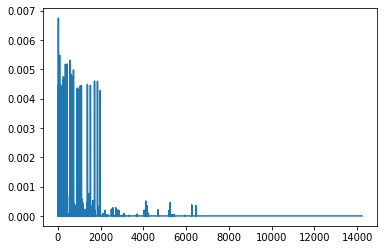

In [144]:
start = time.time()
pg = approximatePageRank(G, {node_target:1}, 0.15, 1e-5)
stop = time.time()
print('Elapsed time:', str(stop-start)[0:8], 'seconds')
plt.plot(pg)
plt.show()

Elapsed time: 1.756749 seconds


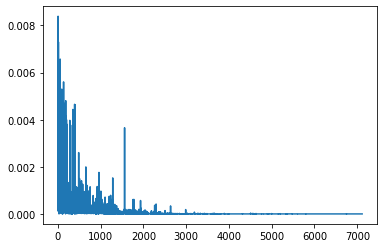

In [9]:
start = time.time()
p = nx.pagerank(G, personalization={node_target:1}, max_iter=40, weight=None)
#p = nx.pagerank(G, personalization={9:1}, max_iter=40, weight=None, tol=1e-2, alpha=0.85)
stop = time.time()
print('Elapsed time:', str(stop-start)[0:8], 'seconds')
p = list(p.values())
p[np.argmax(p)] = 0
plt.plot(p)
plt.show()

TASK 2: speed up using Basis Vector as in http://infolab.stanford.edu/~glenj/spws.pdf